In [ ]:
import random, cv2, os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
!nvidia-smi

Wed Apr 16 09:36:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8


In [ ]:
!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow==1.1.48 --quiet
import roboflow
rf = roboflow.Roboflow(api_key="7rzSffw8YdgPDgo1Effm")
project = rf.workspace("inotech-spain").project("metersocr7")
dataset = project.version(1).download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MetersOCR7-1 in yolov8:: 100%|██████████| 15188/15188 [00:02<00:00, 7558.53it/s]


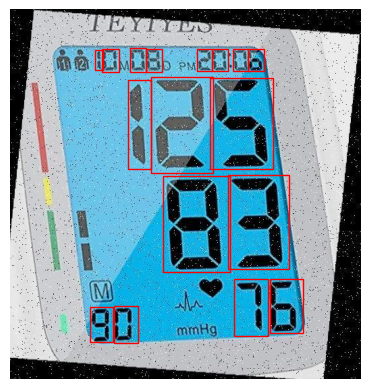

In [ ]:
def show_data(images_dir, labels_dir):
    image_files = os.listdir(images_dir)
    random_image = random.choice(image_files)
    img_path = os.path.join(images_dir, random_image)
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    label_file = os.path.splitext(random_image)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            values = [float(x) for x in line.split()]
            x, y, w, h = values[1] * width, values[2] * height, values[3] * width, values[4] * height
            x1, y1 = x - w / 2, y - h / 2
            rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.gca().add_patch(rect)
    plt.axis('off')
    plt.show()

show_data('/content/datasets/MetersOCR7-1/train/images', '/content/datasets/MetersOCR7-1/train/labels')

## Custom Training

In [ ]:
%cd {HOME}
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=120 imgsz=640 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 220MB/s]
New https://pypi.org/project/ultralytics/8.3.109 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/MetersOCR7-1/data.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False,

In [ ]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content


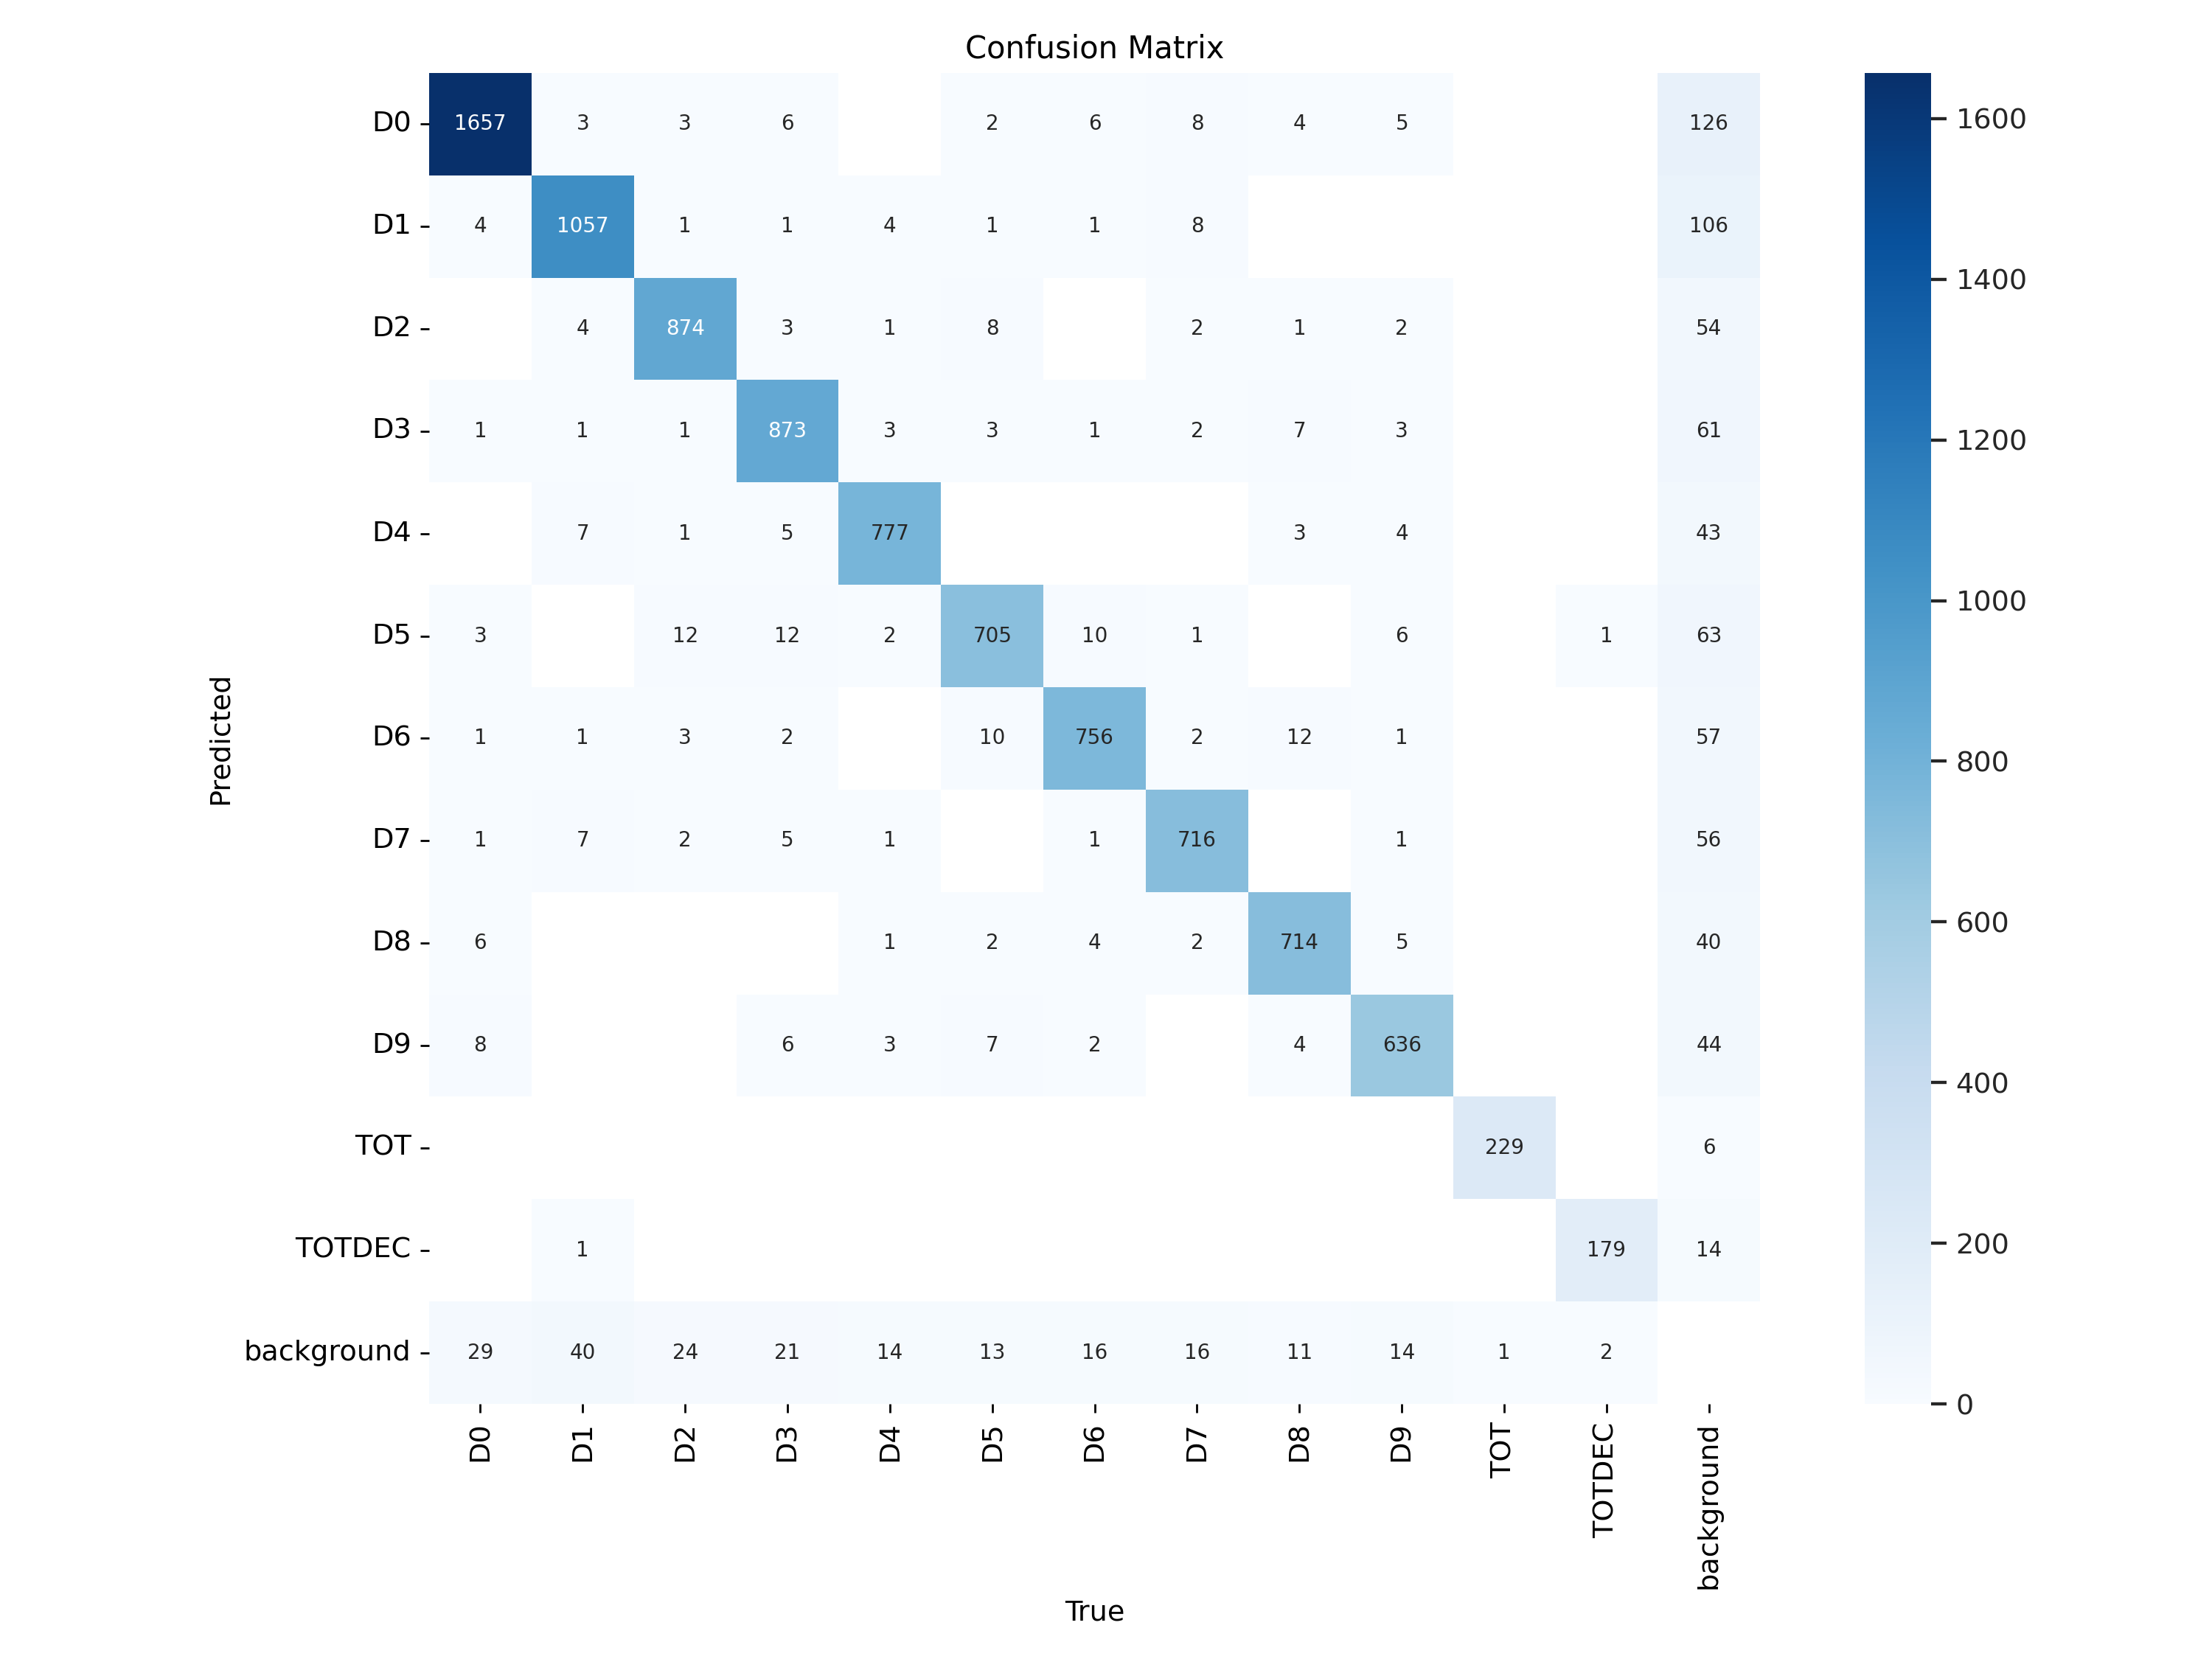

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


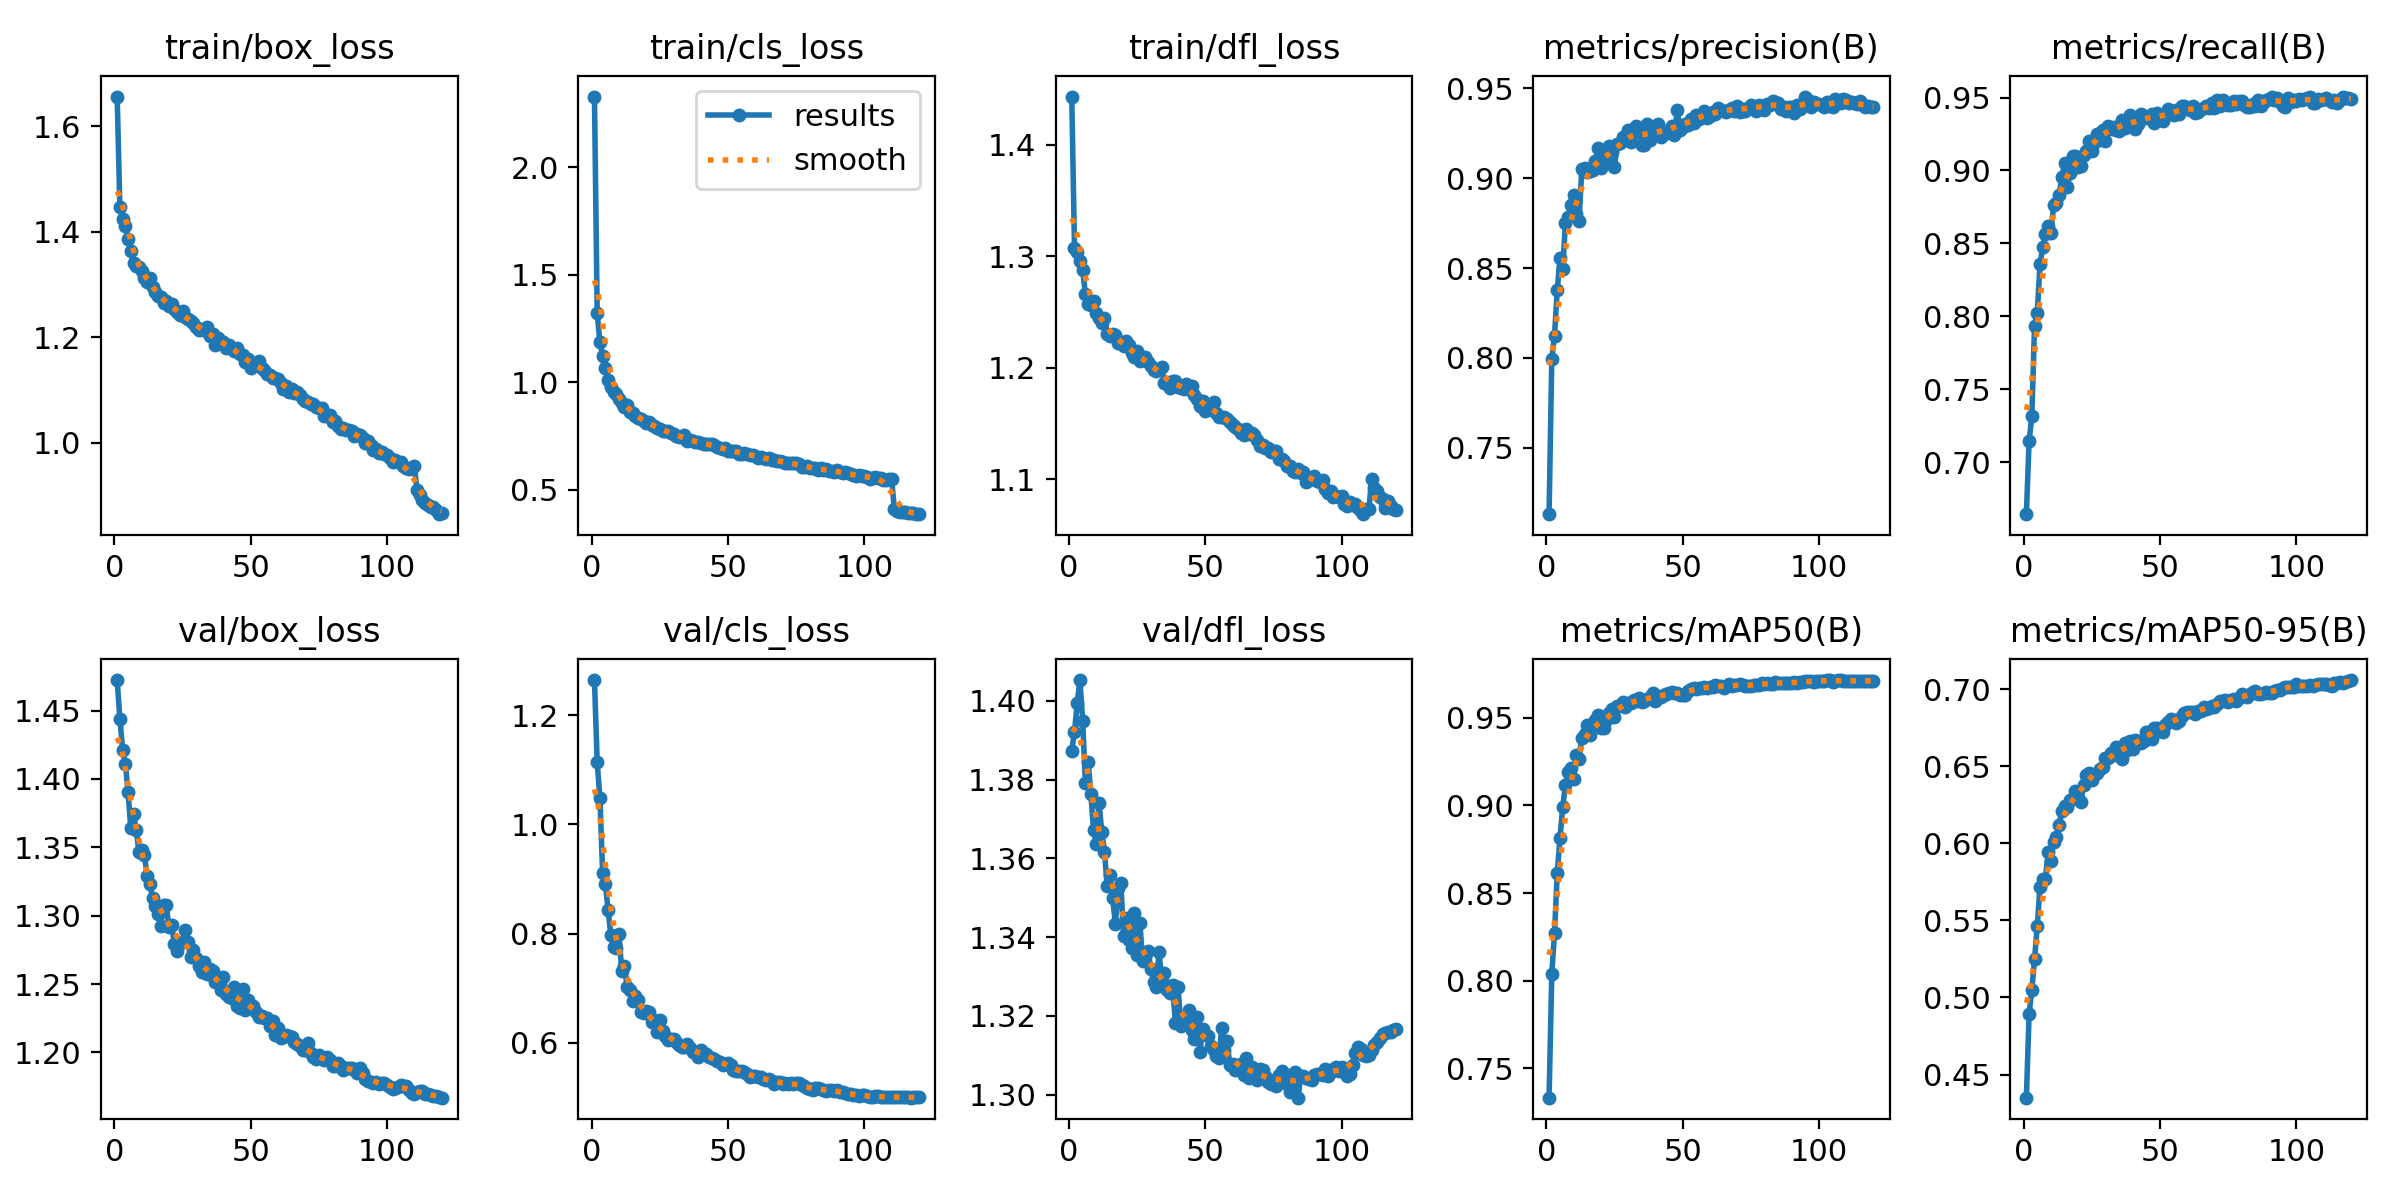

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


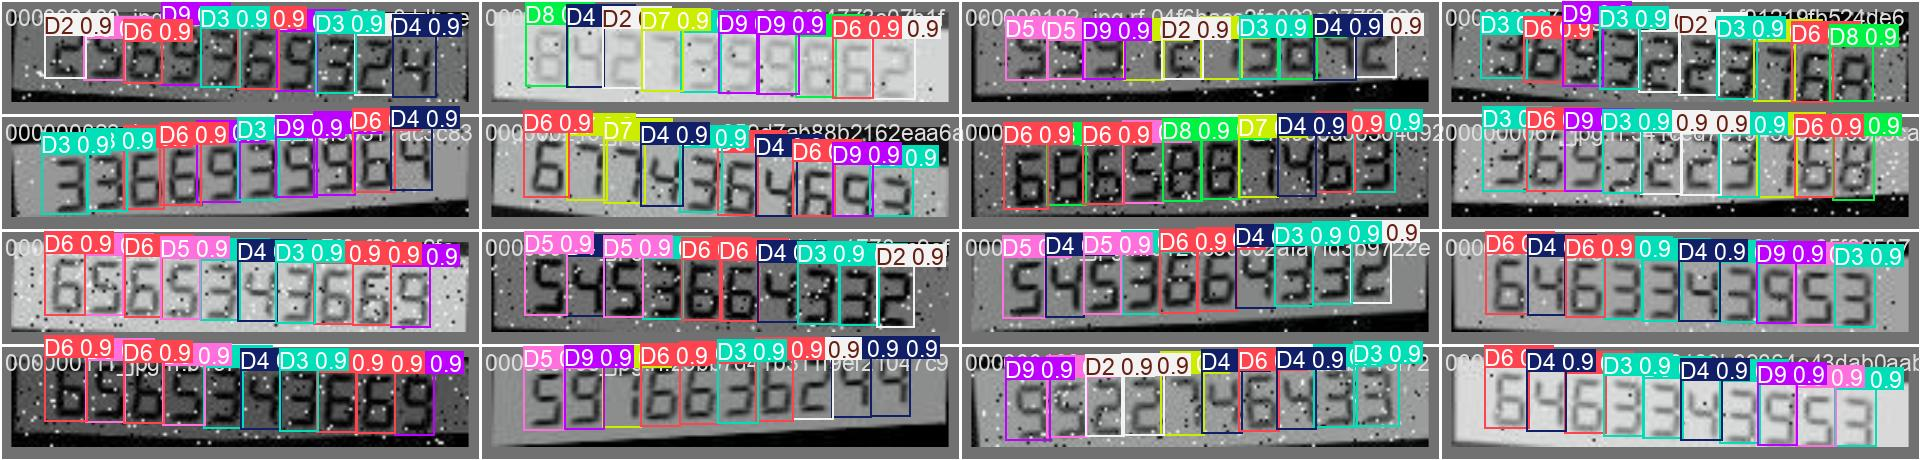

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/datasets/MetersOCR7-1/valid/labels.cache... 1518 images, 0 backgrounds, 0 corrupt: 100% 1518/1518 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 95/95 [00:21<00:00,  4.33it/s]
                   all       1518       9642       0.94       0.95      0.971      0.706
                    D0        951       1710      0.928      0.961      0.967      0.694
                    D1        763       1121      0.923       0.92      0.944      0.564
                    D2        678        921      0.944      0.936      0.971       0.67
                    D3        685        934      0.939      0.931      0.963      0.669
                    D4        595        806       0.95      0.959      0.979        0.7
                    D5

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

image 1/25 /content/datasets/football-players-obj-detection-2/test/images/08fd33_3_6_png.rf.d031da4f257bbf91daf9845051fb9487.jpg: 800x800 1 ball, 19 players, 3 referees, 23.4ms
image 2/25 /content/datasets/football-players-obj-detection-2/test/images/08fd33_9_3_png.rf.509869506accd728341d8426de2f937a.jpg: 800x800 20 players, 1 referee, 22.9ms
image 3/25 /content/datasets/football-players-obj-detection-2/test/images/40cd38_7_6_png.rf.57bcce20df01cee3811f2b3576481f41.jpg: 800x800 1 goalkeeper, 20 players, 1 referee, 22.8ms
image 4/25 /content/datasets/football-players-obj-detection-2/test/images/42ba34_1_5_png.rf.ec272c23ac9c73ba68d85a630b6d2a22.jpg: 800x800 1 goalkeeper, 23 players, 2 referees, 22.8ms
image 5/25 /content/datasets/football-players-obj-detection-2/test/images/42ba34_5_5_png.rf.3fecd509745cf069d